# Random Forests vs. Decision Tree

We are building a random forest on our own and compare it to a decision tree.

First some imports:

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from openml.datasets import get_dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# a random number generator with fixed random state
random_state = 0
rng = np.random.default_rng(random_state)

Next we define our utility functions
- data frame shuffling
- computing the majority vote for each row in the provided data

In [2]:
def shuffle_df(df: pd.DataFrame):
    return df.sample(frac=1).reset_index(drop=True)


def get_majority_vote(predictions: np.ndarray):
    labels = []
    for pred in predictions:
        values, counts = np.unique(pred, return_counts=True)  # we want to count along the rows
        max_index = np.argmax(counts)
        label = values[max_index]
        labels.append(label)
    return np.array(labels)

## Building the Random Forest

### Parameters:
- the number of trees 
- the fraction of data points used to train each tree

We set the number of dimensions for each tree to sqrt(d)

In [41]:
from __future__ import annotations

class RandomForest:
    def __init__(self, n_components: int,
                 frac_observations_per_tree: float | str = 0.3,
                 frac_features_per_tree: float | str = "sqrt"
                ):
        self.n_components = n_components
        self.frac_observations_per_tree = frac_observations_per_tree
        self.frac_features_per_tree = frac_features_per_tree
        self.forest = [DecisionTreeClassifier() for _ in range(n_components)]
        self.features_per_tree = []

    # for now we only support dataframes, but we could extend our forest to also handle numpy arrays
    def fit(self, X: pd.DataFrame, y: pd.Series):
        n_data, n_dimensions = X.shape
        
        # compute the number of features used in each tree
        if self.frac_features_per_tree == "sqrt":
            num_features_per_tree = np.sqrt(n_dimensions).astype(int)
        else:
            num_features_per_tree = int(n_dimensions * self.frac_features_per_tree)
        
        # compute the number of observations used in each tree
        if self.frac_observations_per_tree == "sqrt":
            num_observations_per_tree = np.sqrt(n_data).astype(int)
        else:
            num_observations_per_tree = int(n_data * self.frac_observations_per_tree)
        
        self.features_per_tree = []  # we need to store those features for the prediction phase later on
        all_data_indices = np.arange(len(y))
        for tree in self.forest:
            # subsample data and dimensions
            sampled_indices = rng.choice(all_data_indices, size=num_observations_per_tree, replace=True)  # bootstrap
            sampled_dimensions = rng.choice(X.columns, num_features_per_tree, replace=False)  # choose dimensions randomly
            self.features_per_tree.append(sampled_dimensions)  # store those dimensions

            # train tree
            X_tree = X.loc[sampled_indices, sampled_dimensions]  # select samples and dimensions
            y_tree = y.loc[sampled_indices]
            tree.fit(X_tree, y_tree)  # fit the tree

    def predict(self, X: pd.DataFrame):
        predictions = [
            tree.predict(X[dimensions])  # get the dimensions that belong to each tree
            for dimensions, tree in zip(self.features_per_tree, self.forest)
        ]
        predictions = np.array(predictions).T  # this has shape (#data, #components)
        labels = get_majority_vote(predictions)
        return labels

## Evaluation

### Dataset

We classify measurements from 16 chemical sensors exposed to 6 gases at various levels of concentrations.

There are six possible classes:

1. Ethanol 
2. Ethylene  
3. Ammonia 
4. Acetaldehyde 
5. Acetone 
6. Toluene

- Our goal is to classify the type of gas from the measurements

### Data loading and preprocessing

In [42]:
GAS_IDENTIFICATION = 1476
data = get_dataset(GAS_IDENTIFICATION).get_data()[0]
data.dropna(axis=0, inplace=True)
if "id" in data.columns:
    data = data.drop("id", axis=1)
data = shuffle_df(data)
data.rename({"Class": "class"}, axis=1, inplace=True)
data["class"] = LabelEncoder().fit_transform(data["class"])

We compare four algorithms:

In [43]:
algorithms = {
    "Decision tree": DecisionTreeClassifier(),
    "Random forest (3)": RandomForest(n_components=3),
    "Random forest (10)": RandomForest(n_components=10),
    "Random forest (30)": RandomForest(n_components=30),
    "Random forest (100)": RandomForest(n_components=100),
}

Cross validate each algorithm:

In [44]:
from sklearn.model_selection import KFold

n_folds = 10
folds = KFold(n_splits=n_folds)

df_columns = ["Algorithm", "Fold", "Data", "Accuracy"]
result = []
for i, (train_indices, test_indices) in enumerate(folds.split(data)):
    train, test = data.iloc[train_indices].reset_index(), data.iloc[test_indices].reset_index()
    for alg_name, algorithm in algorithms.items():
        algorithm.fit(train.drop("class", axis=1), train["class"])
        
        y_pred_test = algorithm.predict(test.drop("class", axis=1))
        correct_test = y_pred_test == test["class"]
        acc_test = np.mean(correct_test)
        
        y_pred_train = algorithm.predict(train.drop("class", axis=1))
        correct_train = y_pred_train == train["class"]
        acc_train = np.mean(correct_train)
        
        result.append([alg_name, i, "Train", acc_train])
        result.append([alg_name, i, "Test", acc_test])
        
result_df = pd.DataFrame(result, columns=df_columns)
result_df.groupby(["Algorithm", "Data"]).mean().drop("Fold", axis=1)

Accuracy
Algorithm           Data           
Decision tree       Test   0.974694
                    Train  1.000000
Random forest (10)  Test   0.986772
                    Train  0.994185
Random forest (100) Test   0.992739
                    Train  0.996837
Random forest (3)   Test   0.963551
                    Train  0.977131
Random forest (30)  Test   0.990582
                    Train  0.996382

- Evaluate the algorithms on train and test data
- Store the results in a dataframe

Let's have a look at the result:

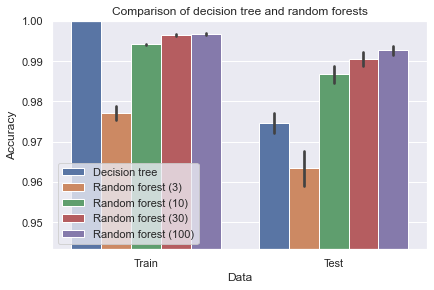

In [45]:
sns.barplot(data=result_df, x="Data", y="Accuracy", hue="Algorithm")
plt.ylim((np.min(result_df["Accuracy"]) - 0.01, 1.0))
plt.title("Comparison of decision tree and random forests")
plt.legend(loc="lower left")
plt.tight_layout(pad=.5)
plt.show()

### Interpretation

- Decision tree has perfect performance on training data but lowest performance on test data
    - overfitting
    
- Performance of random forest increases with number of components but saturates eventually